# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`



In [2]:
import platform
os = platform.system()
if os == 'Windows':
    file_name = 'Reacher/Reacher_Windows_x86_64/Reacher.exe'
elif os == 'Linux':
    file_name = 'Reacher_Linux_NoVis/Reacher.x86_64'

env = UnityEnvironment(file_name= file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def ddpg(n_episodes=300, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    avg_score = []
    len_agents = len(str(num_agents))
    
    env_solv = False
    env_info = env.reset(train_mode=True)[brain_name]
    
    states = env_info.vector_observations
    
    agent_kwargs = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_kwargs) for _ in range(num_agents)]
    assert len(agents) == num_agents
    action = [agent.act(states[idx]) for idx, agent in enumerate(agents)]

    
    
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                 
        for agent in agents:
            agent.reset()
            score = 0
        for t in range(max_t):
            actions = [agent.act(states[idx]) for idx, agent in enumerate(agents)]            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            step_tuple = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, s, a, r, s_, d in step_tuple:
                agent.memory.add(s, a, r, s_, d)
                if ( t % 20 == 0):
                    agent.step(s, a, r, s_, d)
            states  = next_states
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)

        avg = np.mean(scores_deque)
            
            
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, avg, score), end="\n")

        if not env_solv and np.mean(scores_deque) > 30.:
            print("\r\renv __solved__ @ i_episode={i_episode}, w/ avg_score={avg:.2f}\r".format(i_episode=i_episode, avg=avg))
            env_solv = True
        
        
        if i_episode % 100 == 0:
            print("\repisodes: {i_episode}\tavg: {avg:.2f}".format(i_episode=i_episode, avg=avg))

            for idx, agent in enumerate(agents):
                chkpt_path_actor = "actor_" + str(idx).zfill(len_agents) + ".pth"
                torch.save(agent.actor_local.state_dict(), chkpt_path_actor)

                chkpt_path_critic = "critic_" + str(idx).zfill(len_agents) + ".pth"
                torch.save(agent.critic_local.state_dict(), chkpt_path_critic)

    return avg_score


scores = ddpg()

Episode 1	Average Score: 0.00	Score: 0.00
Episode 2	Average Score: 0.00	Score: 0.00
Episode 3	Average Score: 0.00	Score: 0.00
Episode 4	Average Score: 0.07	Score: 0.30
Episode 5	Average Score: 0.18	Score: 0.59
Episode 6	Average Score: 0.28	Score: 0.80
Episode 7	Average Score: 0.38	Score: 0.99
Episode 8	Average Score: 0.46	Score: 0.99
Episode 9	Average Score: 0.54	Score: 1.16
Episode 10	Average Score: 0.62	Score: 1.41
Episode 11	Average Score: 0.73	Score: 1.77
Episode 12	Average Score: 0.83	Score: 1.99
Episode 13	Average Score: 0.92	Score: 1.99
Episode 14	Average Score: 1.00	Score: 1.99
Episode 15	Average Score: 1.10	Score: 2.59
Episode 16	Average Score: 1.22	Score: 2.93
Episode 17	Average Score: 1.37	Score: 3.71
Episode 18	Average Score: 1.50	Score: 3.88
Episode 19	Average Score: 1.65	Score: 4.22
Episode 20	Average Score: 1.78	Score: 4.37
Episode 21	Average Score: 1.91	Score: 4.53
Episode 22	Average Score: 2.04	Score: 4.65
Episode 23	Average Score: 2.18	Score: 5.38
Episode 24	Average S

Episode 183	Average Score: 40.18	Score: 54.39
Episode 184	Average Score: 40.45	Score: 54.77
Episode 185	Average Score: 40.72	Score: 54.91
Episode 186	Average Score: 40.98	Score: 55.15
Episode 187	Average Score: 41.25	Score: 55.47
Episode 188	Average Score: 41.52	Score: 55.56
Episode 189	Average Score: 41.78	Score: 55.87
Episode 190	Average Score: 42.05	Score: 55.87
Episode 191	Average Score: 42.32	Score: 56.31
Episode 192	Average Score: 42.60	Score: 56.38
Episode 193	Average Score: 42.86	Score: 56.53
Episode 194	Average Score: 43.13	Score: 56.64
Episode 195	Average Score: 43.40	Score: 57.18
Episode 196	Average Score: 43.66	Score: 57.18
Episode 197	Average Score: 43.93	Score: 57.26
Episode 198	Average Score: 44.19	Score: 57.37
Episode 199	Average Score: 44.45	Score: 57.61
Episode 200	Average Score: 44.72	Score: 57.63
episodes: 200	avg: 44.72
Episode 201	Average Score: 44.99	Score: 57.94
Episode 202	Average Score: 45.26	Score: 58.45
Episode 203	Average Score: 45.53	Score: 58.62
Episode 2

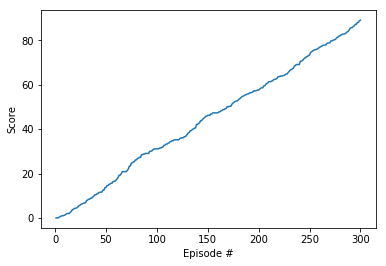

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
env.close()

When finished, you can close the environment.